In [115]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from sklearn.model_selection import train_test_split
import pandas as pd

seed=42 # to ensure reproducibility
import numpy
numpy.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)

# Airline data
## Performing train/test split

In [18]:
full_data = pd.read_csv('data/Tweets.csv')

In [21]:
full_data.shape

(14640, 15)

In [30]:
train, test = train_test_split(full_data, train_size=0.90, random_state=seed)

In [38]:
train.to_csv("data/original_train.csv")
test.to_csv("data/original_test.csv")

In [ ]:
cols = ["airline_sentiment", "text"]
train[cols].to_csv("data/filtered_train.csv", index=False)
test[cols].to_csv("data/filtered_test.csv", index=False)
train["text"].to_csv("data/filtered_train_text.csv", index=False)

In [101]:
train = pd.read_csv('data/original_train.csv', index_col=0)

In [47]:
train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1372,569753797704024065,negative,0.6851,Can't Tell,0.3596,United,NaN,JasonArbaugh,NaN,0,@united Yes I did. We headed out to de-ice 5 ...,NaN,2015-02-22 23:01:05 -0800,NaN,NaN
14532,569603156927246336,negative,1.0000,Flight Booking Problems,0.6964,American,NaN,JasonShaw2,NaN,2,@AmericanAir missing a full days of work thank...,NaN,2015-02-22 13:02:29 -0800,Belleville,Eastern Time (US & Canada)
10029,569564566272811008,negative,1.0000,Customer Service Issue,0.6774,US Airways,NaN,CDarnall1,NaN,0,@USAirways your mobile app is horrible! Needs...,NaN,2015-02-22 10:29:09 -0800,"Lexington, KY",Eastern Time (US & Canada)
12087,570296986827694080,negative,1.0000,Flight Booking Problems,0.3606,American,NaN,lilirr,NaN,0,@AmericanAir Checked in on app since yesterday...,NaN,2015-02-24 10:59:31 -0800,NaN,Mountain Time (US & Canada)
2087,569376145000390656,negative,1.0000,Customer Service Issue,1.0000,United,NaN,tweets1971,NaN,0,@united we have tried to change our flight THR...,NaN,2015-02-21 22:00:26 -0800,Boston,NaN


## Data cleanup

### Any missing values in the key features?

In [40]:
train.isnull().sum().sort_values(ascending = False)

negativereason_gold             13147
airline_sentiment_gold          13140
tweet_coord                     12250
negativereason                   4922
user_timezone                    4319
tweet_location                   4251
negativereason_confidence        3698
tweet_created                       0
text                                0
retweet_count                       0
name                                0
airline                             0
airline_sentiment_confidence        0
airline_sentiment                   0
tweet_id                            0
dtype: int64

All we care about is text, airline_sentiment, and airline_confidence, none of which have null values. So we don't have to impute anything missing

## Data Exploration
### Class distribution

In [49]:
def value_count_proportions(series):
    num_rows = len(series)
    return {
        value: (count / num_rows)
        for value, count
        in series.value_counts().items()
    }

In [97]:
airline_sent_proportions = value_count_proportions(train['airline_sentiment'])
airline_sent_proportions

{'negative': 0.6264420157862781,
 'neutral': 0.21227990285367335,
 'positive': 0.16127808136004856}

Clearly, we can see this data is imbalanced. But that makes sense: people generally tweet at airline companies to lodge complaints, not to heap praise for safe flights.
#### I will preserve this class imbalance since it represents the world (and, most likely, the test set that I created above).

Now, let's see how the confidences are distributed within the different sentiments.

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

In [89]:
sent_to_conf = {
    sentiment: train[train["airline_sentiment"] == sentiment][
        "airline_sentiment_confidence"
    ]
    for sentiment in ["positive", "neutral", "negative"]
}

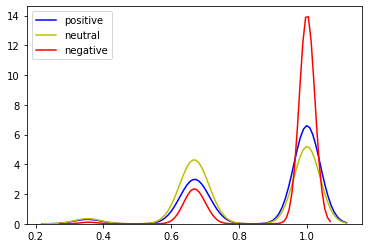

In [81]:
sns.kdeplot(sent_to_conf["positive"], label="positive", color="b")
sns.kdeplot(sent_to_conf["neutral"], label="neutral", color="y")
sns.kdeplot(sent_to_conf["negative"], label="negative", color="r")

Vaguely trimodal. I don't know how these confidences were generated.

Looks like there is more uncertainty around neutral / positive data (the minority classes).
The data is most confident about negative labels, less confident about positive labels, and least confident about neutral labels.

## Exploring what a "typical" tweet looks like of each sentiment

In [110]:
def print_top_10_sorted_tweets_with_sentiment(sentiment):
    top_rows = train[train["airline_sentiment"] == sentiment].sort_values(
        by="airline_sentiment_confidence", ascending=False
    )
    for _, tweet in top_rows["text"].iloc[:10].items():
        print(tweet)

### Negative

In [111]:
print_top_10_sorted_tweets_with_sentiment('negative')

@united we would...how do I contact you to discuss? A few poor experiences with customer service but would give it a shot!
@SouthwestAir customer svc worse than the #WinterWeather !  Flight Cancelled Flighted, website malfunction, on hold for &gt;1:34. http://t.co/PgwUkrpMOx
@VirginAmerica I'm trying to check into my 10:50AM CT flight tmm on the desktop website and it's not working (some sort of caching bug) SOS
@JetBlue not an issue but I think training &amp; information would help. Great ppl but service needs to switch from individual to group better
@USAirways no. Other than being on my credit card statement, I have not received anything from you and so I have no way to look it up myself
@united what if business as usual meant dropping the bully mentality and fostering inspiration for a greater business #EmployeeRelations
@SouthwestAir you Cancelled Flightled my flight to BNA. I have flight from BNA 2 MDW tomorrow AM. You stranded me in DEN. I've been on hold all day
@USAirways I've

Complaints relating to:
- customer service frustrations (during discussion, getting a hold of them)
- Flight cancellations
- Checkins not working
- Rebooking not working
- Airlines "bullying" employees

Sounds about right

### Neutral

In [112]:
print_top_10_sorted_tweets_with_sentiment('neutral')

@AmericanAir What are Preferred Seats?
@USAirways @AmericanAir Flying from Orlando to Philly to Charlotte to Lynchburg. Saw advisory re Philly. Wld like to fly from Orl to Char
@USAirways how do I reserve my seat on the AA flight I transfer to from ORD to EVV?
@AmericanAir You guys are the talk of the Americans down here in Ecuador! Read this! https://t.co/5ON3KlzVMT
@USAirways call Gate D9 in CLT and get me on this flight
@united A3 Gold. So the international baggage limit apply when booked on 1 ticket,even for a domestic leg?  What if I travel with 2 friends?
@united Was on NH10 on United ticket, rerouted to IAD due to weather in JFK. Can you get us home on United 5713 or 3277?
😂😂 RT @JetBlue: Our fleet's on fleek. http://t.co/rinzYSK6kI
@united I need the phone number to baggage claim in LAX, my mom left her phone and someone called saying they would put it there but on
@JetBlue's CEO battles to appease passengers and Wall Street - Lake Wylie #Pilot http://t.co/jgor0vdI3S


- Customer questions / requests
- Headlines

I'm not sure about some of these.
"@AmericanAir You guys are the talk of the Americans down here in Ecuador! Read this!"
  -- this sounds pretty positive..."talk of the town" is a positive phrase
😂😂 is pretty positive too
but I guess the rest of them don't have very emotional language (although you can tell the person issuing the command to "get me on this flight" is probably a little stressed)

Wouldn't say that there is any sort of distinctive language / key words that define "neutral." Maybe the question mark character?

### Positive

In [113]:
print_top_10_sorted_tweets_with_sentiment('positive')

@SouthwestAir replacing @vitaminwater with beer! Bravo!👏👏 Cheers! 🍻🍻 @Leinenkugels @DosEquis @FatTire
@united  Thank you for a wonderful global first class flight on your 777 to FRA. Great service. (cont) http://t.co/46n9kDcsxU
@AmericanAir Joanne from your San Diego staff was phenomenal! Give that girl a raise. She handled our #flightnightmare better than anyone.
@USAirways please give Tara G a pat on the back and praise.  She was very very helpful.  She is at PHL member lounge
@JetBlue Love you, bae. #JetBae
@SouthwestAir 👏👏👏 on that Late Flightst ad. Makes me happy to be flying you in a few days. #BETHonors
@JetBlue thanks. Line moved quick. Already done.
@SouthwestAir is the best airline hands down. Amazing customer service, bags free and affordable flights. #happycamper
@JetBlue here you go... Your napkins pretty much say it all! http://t.co/OxY1Jnpjm3
@SouthwestAir All's well. I got comped with multiple other bags which just made my day! http://t.co/1AAVvoREpH


- good customer service
- Thanks to flight staff
- praise
- happy to be flying
- convenience of amenities

# Sentiment-140
Since one of the easiest ways to improve a model is to train with more data, I figured I could try using additional tweets for this task. I couldn't find another dataset of tweets specifically related to airlines.

The [sentiment 140 dataset](https://www.kaggle.com/kazanova/sentiment140) contains more generic tweets. They are also labeled by sentiment - there are only positive and negative tweets, as opposed to the airline dataset, which includes positive, negative, and neutral tweets.

I don't want to blindly merge sentiment-140 with the airline dataset for a few reasons:
- Sentiment-140 is much larger (1.6M rows) than the airline dataset (14k rows). If I were to train a language model on such a combined dataset, then it would probably learn a lot more about how to represent generic conversations on twitter than specifically how to represent airline-directed tweets. I want the language model to create a good latent representation of airline-specific tweets.
- Different distribution of labels. As you can see below, the ratio of negative : positive tweets in sentiment-140 (1:1) is different than it is in the airline dataset (3:1). Since I sampled the test dataset uniformly randomly from the original dataset, I need to make sure that the distribution of labels in train matches that in test.
- Different meaning of the labels. I imagine that the negative airline sentiments are specifically focused on frustration and anger, whereas the sentiment-140 dataset probably includes a wider swath of negative emotions - depression, melancholy, anxiety, etc. This means that the 'negative' label in the sentiment-140 dataset probably represents something different than the 'negative' label in the airline dataset.

Therefore, I will only use the sentiment-140 dataset to augment the training of the language model, to give it a better understanding of twitter vernacular and move it further from formal wikipedia English, but **I won't use it to train the derivative classifier.**

In [37]:
sentiment_140_full = pd.read_csv('data/trimmed_sentiment_140.csv')

In [118]:
sentiment_140_full

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [32]:
sentiment_140_full.shape

(1600000, 2)

In [27]:
sentiment_140_full.target.value_counts()

4    800000
0    800000
Name: target, dtype: int64

# Joining airline tweets with sentiment 140
Sentiment 140 contains only positive and negatively-sentimented tweets, no neutrals.
I want to combine sentiment 140 with the airline data, but not too many that the airline tweets will be crowded out.
What I'll do is create a new dataset, which contains as many positive sentiment140 tweets as there are positive airline tweets, same for negative.

I'll simply double the airline neutrals so that **the ratio of airline:sentiment140 is 1:1 and the ratio of positive : neutral : negative is the same as it is in the airline dataset**

In [116]:
# https://www.kaggle.com/kazanova/sentiment140
NEGATIVE_LABEL = 0
POSITIVE_LABEL = 4

In [78]:
sent140_positive = (
    # get all positive sent140 tweets
    sentiment_140_full[sentiment_140_full['target'] == POSITIVE_LABEL]
    # get as many sent140 positives as there were airline positives
    .sample(
        train['airline_sentiment'].value_counts()['positive']
    )
    .rename(columns={'target': 'airline_sentiment'})
    .replace({POSITIVE_LABEL: 'positive', NEGATIVE_LABEL: 'negative'})
)
sent140_positive

,airline_sentiment,text
1072846,positive,@yvettenicole hi by the way.
1006546,positive,http://twitpic.com/5ok2z - lï¿½ngos yummy.. an...
1599823,positive,guilty pleasure - yikes i wish i could afford...
813794,positive,@mileycyrus p.s. i love you too
1582547,positive,"@heartmisuse I have 22,646 followers on one of..."
...,...,...
1128195,positive,"Iphone users, lol...Sonic is in the app store!..."
1292841,positive,"flatmates are all out, house to myself! make s..."
1292742,positive,@iamMarkRonson heres a reply... now that you h...
844598,positive,"4:20 im not too old at all, where's that burn..."


In [79]:
sent140_negative = (
    sentiment_140_full[sentiment_140_full['target'] == NEGATIVE_LABEL]
    .sample(
        train['airline_sentiment'].value_counts()['negative']
    )
    .rename(columns={'target': 'airline_sentiment'})
    .replace({POSITIVE_LABEL: 'positive', NEGATIVE_LABEL: 'negative'})
)
sent140_negative

,airline_sentiment,text
442888,negative,For some reason I feel a bit upset that the in...
20906,negative,@ianshepherd First of many no doubt
575540,negative,"omg, i would like to be in texas also! i mean..."
603680,negative,@ShoesforGeorgia so did mine but technically ...
368306,negative,@john_lo The audio wasn't recording
...,...,...
781978,negative,"my indentation issue is gone now, and I really..."
469966,negative,I messed up the colour on my TV @yelyahwilliam...
316499,negative,Need to do the week's food shopping as the cup...
30161,negative,"sick! fever-ish, flu-ish, headache-ish"


In [63]:
airline_neutral = train[train['airline_sentiment'] == 'neutral']

In [80]:
sent140_and_airline = pd.concat(
    [
        train,
        sent140_positive,
        airline_neutral,
        sent140_negative
    ]
)
assert sent140_and_airline.shape[0] == train.shape[0] * 2
sent140_and_airline

,airline_sentiment,text
0,negative,@united Yes I did. We headed out to de-ice 5 ...
1,negative,@AmericanAir missing a full days of work thank...
2,negative,@USAirways your mobile app is horrible! Needs...
3,negative,@AmericanAir Checked in on app since yesterday...
4,negative,@united we have tried to change our flight THR...
...,...,...
781978,negative,"my indentation issue is gone now, and I really..."
469966,negative,I messed up the colour on my TV @yelyahwilliam...
316499,negative,Need to do the week's food shopping as the cup...
30161,negative,"sick! fever-ish, flu-ish, headache-ish"


In [83]:
sent140_and_airline = sent140_and_airline.sample(frac=1).reset_index(drop=True)

In [84]:
sent140_and_airline['text'].to_csv('~/airline/sent140_and_airline_balanced_text_only.csv', index=False)